# Investigate if numeric encoding can lead to a smoother response surface.

## Main Questions

* Do we get a more smooth response surface, if we use
    * numeric input encoding
    * use narrow network

In [95]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'n_enc2'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines'
bs_merged_folder = f'../../data/training/baselines_merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [97]:
baseline_df

,name,value,cv_split,epoch,set,baseline
0,loss,3.053400,0,0,None,NaN
1,mean_absolute_error,7.679183,0,0,train,NaN
2,accuracy,0.030038,0,0,train,NaN
3,mean_absolute_error,7.546326,0,0,test,NaN
4,accuracy,0.012780,0,0,test,NaN
...,...,...,...,...,...,...
9995,loss,1.749402,19,990,None,onehot_mlp
9996,mean_absolute_error,3.049074,19,990,train,onehot_mlp
9997,accuracy,0.492141,19,990,train,onehot_mlp
9998,mean_absolute_error,3.331210,19,990,test,onehot_mlp


In [98]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size']
metrics_df[to_string] = metrics_df[to_string].astype(str)
synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['lr', 'regularisation', 'x_encoding', 'layers', 'y_encoding', 'hidden_size']


In [102]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990)
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline    name               
onehot_mlp  accuracy               0.489901
            mean_absolute_error    2.959608
Name: value, dtype: float64

## Overview

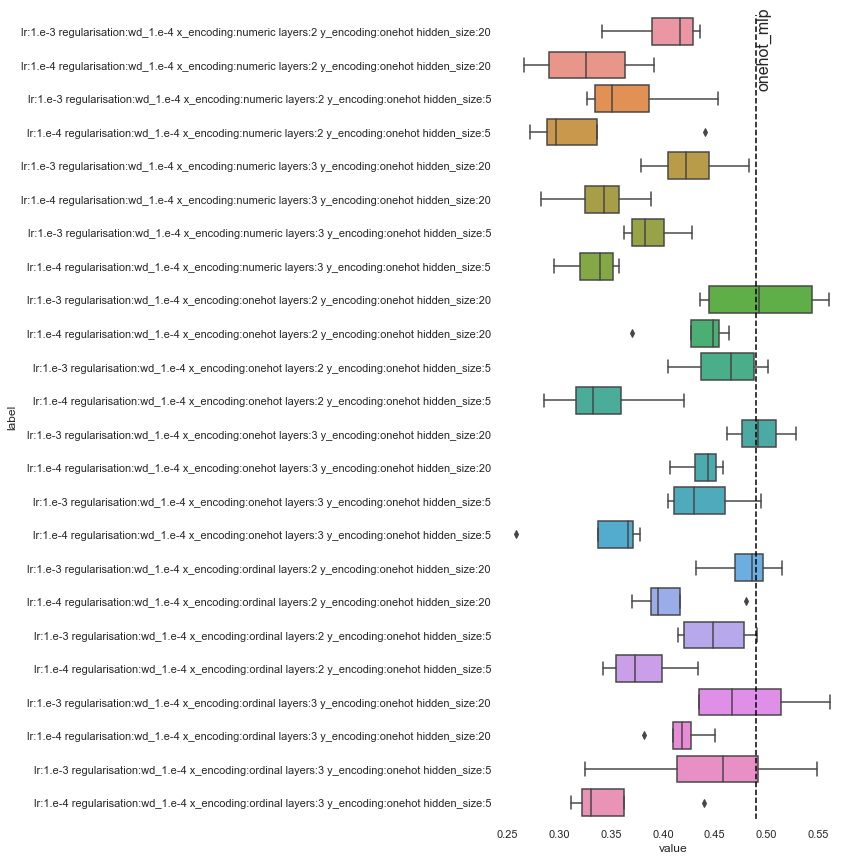

In [116]:
metric_name = 'accuracy'

w = (
    (metrics_df['name'] == metric_name) &
    (metrics_df['set'] == 'test') & 
    # (metrics_df['layers'] == '3') & 
    # (metrics_df['hidden_size'] == '20') & 
    # (metrics_df['lr'] == '1.e-3') & 
    # (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
# df['y_ordinal'] = df['y_ordinal'].astype(str)
df = df.sort_values(['x_encoding', 'layers', 'hidden_size',  'lr'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [ ]:
label_ref = {
    # 'regularisation': 'none',
    'x_encoding': 'numeric',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [ ]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    # (metrics_df['y_encoding'] != 'numeric') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.315826,0.018972,16.647026,3.180187e-62,0.278641,0.353010
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.069090,0.021907,3.153792,1.611638e-03,0.026153,0.112026
"C(x_encoding, Treatment(reference='numeric'))[T.ordinal]",0.058838,0.023998,2.451814,1.421382e-02,0.011803,0.105873
"C(x_encoding, Treatment(reference='numeric'))[T.onehot]:C(hidden_size, Treatment(reference='5'))[T.20]",0.049474,0.023998,2.061588,3.924697e-02,0.002439,0.096508
"C(x_encoding, Treatment(reference='numeric'))[T.onehot]",0.042064,0.023998,1.752828,7.963148e-02,-0.004971,0.089099


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [ ]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('P>|z|')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,7.109073,0.250650,28.362496,5.870074e-177,6.617807,7.600339
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-3.100759,0.289426,-10.713470,8.800068e-27,-3.668024,-2.533494
"C(x_encoding, Treatment(reference='numeric'))[T.ordinal]",-2.892732,0.317051,-9.123883,7.247989e-20,-3.514140,-2.271325
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]:C(x_encoding, Treatment(reference='numeric'))[T.ordinal]",1.834124,0.317051,5.784956,7.253112e-09,1.212716,2.455531
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]:C(hidden_size, Treatment(reference='5'))[T.20]",1.240027,0.258871,4.790140,1.666653e-06,0.732650,1.747404
"C(hidden_size, Treatment(reference='5'))[T.20]",-1.184786,0.289426,-4.093568,4.247847e-05,-1.752051,-0.617521
"C(x_encoding, Treatment(reference='numeric'))[T.onehot]",-1.173336,0.317051,-3.700785,2.149336e-04,-1.794744,-0.551928
"C(x_encoding, Treatment(reference='numeric'))[T.onehot]:C(hidden_size, Treatment(reference='5'))[T.20]",-0.809424,0.317051,-2.552982,1.068050e-02,-1.430832,-0.188017
"C(x_encoding, Treatment(reference='numeric'))[T.ordinal]:C(layers, Treatment(reference='2'))[T.3]",0.764712,0.317051,2.411957,1.586715e-02,0.143305,1.386120
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]:C(x_encoding, Treatment(reference='numeric'))[T.onehot]",0.763900,0.317051,2.409396,1.597894e-02,0.142493,1.385308


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [ ]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is lr:1.e-3 regularisation:wd_1.e-4 x_encoding:onehot layers:3 y_encoding:onehot hidden_size:20.
                       name    set     value
342612             accuracy   test  0.491948
342614  mean_absolute_error   test  2.902741
342618             accuracy  train  0.496944
342620  mean_absolute_error  train  3.004541
Best performance for metric accuracy is lr:1.e-3 regularisation:wd_1.e-4 x_encoding:onehot layers:2 y_encoding:onehot hidden_size:20.
                       name    set     value
342456             accuracy   test  0.492454
342458  mean_absolute_error   test  3.016180
342462             accuracy  train  0.491879
342464  mean_absolute_error  train  3.047066


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

lr=1.e-3|regularisation=wd_1.e-4|x_encoding=onehot|y_encoding=onehot|epoch=990


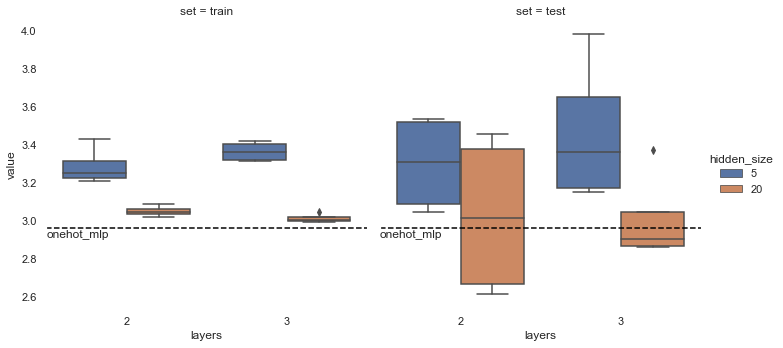

In [132]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['layers', 'hidden_size']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

### Hidden Size and learning rate

regularisation=wd_1.e-4|x_encoding=onehot|layers=3|y_encoding=onehot|epoch=990


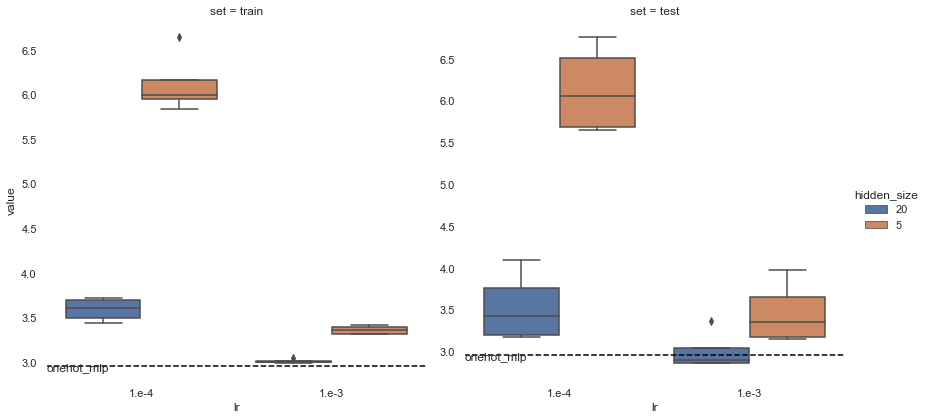

In [134]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['hidden_size', 'lr']
metric_name = 'mean_absolute_error'

selection = {k: v for k, v in selection.items() if k not in focus}
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)
fg = sns.catplot(data=metrics_df[w1 & w2], hue=focus[0], x=focus[1], y='value', col='set', kind='box', sharey=False, height=6)
print('|'.join(f'{k}={v}' for k, v in selection.items()))


for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

#### Results

* Increase in hidden size very beneficial
* learning rate crucial

## Confusion Matrix

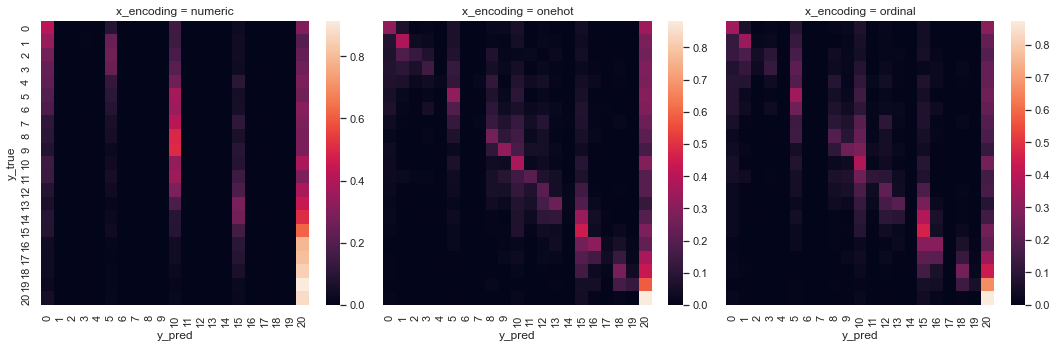

In [ ]:
selection = best_labels['accuracy'].copy()

w = confusion_matrix_df['set'] == 'test'

df = confusion_matrix_df[w].copy()

focus_dimension = 'x_encoding'

selection.pop(focus_dimension)
# selection['regularisation'] = 'wd_1.e-6'

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = df[w]

# w2 = df[focus_dimension].isin(['none', 'wd_1.e-3', 'wd_1.e-4'])
# df = df[w2]

df = df.sort_values(focus_dimension)

def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])[values].sum().reset_index()
    dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    # dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true',y='y_pred', values='value')

fg = sns.FacetGrid(df, col=focus_dimension, col_wrap=3, height=5)
fg.map_dataframe(plot_heatmap)

In the numeric encoding, the model is only taking actions that are a multiple of 5.

## Response surface

## 

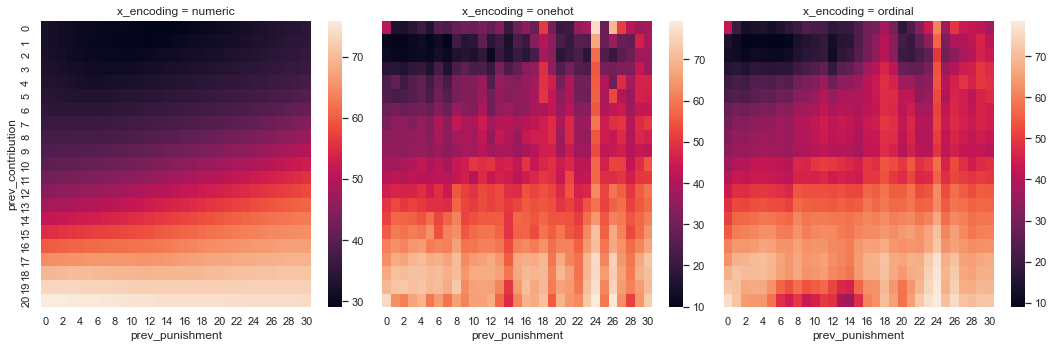

In [ ]:
selection = best_labels['accuracy'].copy()
df = synthethetic_df.copy()

focus_dimension = 'x_encoding'

selection.pop(focus_dimension)
# selection['regularisation'] = 'wd_1.e-6'

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = df[w]

# w2 = df[focus_dimension].isin(['none', 'wd_1.e-3', 'wd_1.e-4'])
# df = df[w2]

df = df.sort_values(focus_dimension)

if df['y_encoding'].unique()[0] == 'ordinal':
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']


def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])['exp_contribution'].sum()
    dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_contribution',y='prev_punishment', values='exp_contribution')

fg = sns.FacetGrid(df, col=focus_dimension, col_wrap=3, height=5)
fg.map_dataframe(plot_heatmap)

Numeric encoding is creating nicely smooth response surfaces. 